## Importing the Data into Python
We'll be using [pandas](https://pandas.pydata.org/docs/user_guide/index.html#user-guide), a data analysis package for python.

The first step is to import the package, and use it to import the data as [dataframes](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html). Since the data is stored as [CSV](https://en.wikipedia.org/wiki/Comma-separated_values) files, we should use [read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html#pandas-read-csv)

In [1]:
# original dataset from the GroupLens Research Project at the University of Minnesota
import pandas as pd
import numpy as np

In [2]:
# read the data into dataframes
df_movies = pd.read_csv(r'./movies.csv')
df_ratings = pd.read_csv(r'./ratings_simplified.csv')

Lets take a look into the dataframes.

In [3]:
df_movies.info()
df_movies

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
62418,209157,We (2018),Drama
62419,209159,Window of the Soul (2001),Documentary
62420,209163,Bad Poems (2018),Comedy|Drama
62421,209169,A Girl Thing (2001),(no genres listed)


In [4]:
df_ratings.info()
df_ratings

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   userId   int64
 1   movieId  int64
 2   rating   int64
dtypes: int64(3)
memory usage: 572.2 MB


,userId,movieId,rating
0,1,296,10
1,1,306,7
2,1,307,10
3,1,665,10
4,1,899,7
...,...,...,...
25000090,162541,50872,9
25000091,162541,55768,5
25000092,162541,56176,4
25000093,162541,58559,8


## Metrics
To identify the clients preferences, we need to determine what movies we should ask their
opinions on. For now, lets just collect the total number of votes and average rating each movie has. Additionally, lets also compute the variability in the ratings. To do so, we can use the [groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) function available for dataframes.

In [5]:
# get metrics
df_dev = df_ratings.groupby('movieId')['rating'].std()
df_mean = df_ratings.groupby('movieId')['rating'].mean()
df_count = df_ratings.groupby('movieId')['rating'].count()

Lets merge these metrics together in a single dataframe. It is important to note that for a particular user their movie ratings might have correlations, however when aggregated over all users, this correlation gets weaker. Instead of having a complicated algorithm to find the best movies to guage preferences, lets just take the most rated movies, in descending order.
For convenience, lets also add the movie title into the same dataframe.

In [6]:
# merge
df_metrics = pd.concat([df_count, df_mean, df_dev], axis=1)
df_metrics.columns = ['count', 'mean', 'deviation']
# filter
df_metrics.drop(df_metrics[df_metrics['count'] < 10000].index, inplace = True)

In [7]:
# sort and add name to df_metrics
df_metrics.sort_values('count', ascending=False, inplace=True)
df_movies.set_index = 'movieId'
df_movies.drop(columns='genres', inplace=True, errors='ignore')
df_metrics = pd.merge(df_metrics, df_movies, on='movieId', how='left')
df_metrics.reindex()

,movieId,count,mean,deviation,title
0,356,81491,8.096023,1.877620,Forrest Gump (1994)
1,318,81482,8.827152,1.520888,"Shawshank Redemption, The (1994)"
2,296,79672,8.377824,1.917676,Pulp Fiction (1994)
3,593,74127,8.302683,1.723758,"Silence of the Lambs, The (1991)"
4,2571,72674,8.308198,1.825748,"Matrix, The (1999)"
...,...,...,...,...,...
583,2078,10052,7.300537,1.866745,"Jungle Book, The (1967)"
584,56782,10044,7.965452,1.876157,There Will Be Blood (2007)
585,529,10037,7.698416,1.644286,Searching for Bobby Fischer (1993)
586,96610,10012,7.310328,1.680528,Looper (2012)


## Generating Client Profile
Now, we need to query the client on these movies to generate their profile, lets prompt the client until they provide 10 valid ratings. We need to keep track of the rating, and the movieId. Additionally, we need to ensure that the rating is valid. Lets start be telling
the client what we need from them.

In [8]:
client_ratings = 0
required_ratings = 10
# Prompt client
print("Hello viewer! Before we can start recommending movies,")
print( "We need you to rate a few movies to compute your preference profile.")
print( "Please rate the following movies on a scale of 1 to 10.")
print( "If you wish to skip rating a movie, press ENTER.")

Hello viewer! Before we can start recommending movies,
We need you to rate a few movies to compute your preference profile.
Please rate the following movies on a scale of 1 to 10.
If you wish to skip rating a movie, press ENTER.


Now, we need to write code that iterates over the movies we have curated, and asks the client to rate them until we have 10 valid ratings. We can do this using the [iterrows](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iterrows.html) feature for dataframes. Lets store the ratings in a dictionary for now. Use the function given below, to collect the client response.

In [9]:
def prompt_till_valid(movie_title):
    client_prompt = "{}: ".format(movie_title)
    while True:
        client_response = input(client_prompt)
        # skip if necessary
        if (client_response == ''):
            break
        # else, convert input to float
        try:
            client_response = float(client_response)
        except ValueError:
            print("Sorry, we can only accept numerical ratings")
        else:
            # check if rating in 1-10
            if (1 <= client_response <= 10):
                break
            print("Sorry, ratings must be between 1 and 10")
    return client_response

In [10]:
client_ratings = {}
required_ratings = 10
for index, movie in df_metrics.iterrows():
    client_response = prompt_till_valid(movie['title'])
    # add to dictionary if valid rating
    if (client_response != ''):
        client_ratings[movie['movieId']] = client_response
    # check if we have enough ratings
    if (len(client_ratings) == required_ratings):
        break

Forrest Gump (1994): 1
Shawshank Redemption, The (1994): 2
Pulp Fiction (1994): 3
Silence of the Lambs, The (1991): 4
Matrix, The (1999): 5
Star Wars: Episode IV - A New Hope (1977): 6
Jurassic Park (1993): 7
Schindler's List (1993): 8
Braveheart (1995): 9
Fight Club (1999): 10


## Computing Cosine Similarity
Now, we have enough ratings to start computing the similarity. First, lets create a simplified ratings dataframe to compute the similarity. We can drop ratings of movies that the client has not rated.

In [11]:
client_movies = list(client_ratings.keys())
df_simple = df_ratings
df_simple.drop(df_simple[~df_simple.movieId.isin(client_movies)].index, inplace=True, errors='ignore')

Additionally, to make sure the similarity scores are accurate, lets only consider users that have rated at least half the movies the client has.

In [12]:
df_simple = df_simple[df_simple['userId'].map(df_simple['userId'].value_counts()) >= required_ratings / 2]

Now, lets create a structure to store the similarity between the client and every other user. We can use this to identify the most similar users.

Recalling the formula for calculating cosine similarity, we need to compute user and client magnitudes, as well as pairwise dot products. First, lets create a dataframe to store these values for each user.

In [13]:
df_similarity = pd.DataFrame(index=df_simple['userId'].unique(), 
                             columns = ['squaredSum', 'dotProd'])
df_similarity.fillna(0, inplace=True)

Now, to compute these values, we can do this iteratively as we go over the simplfied ratings dataframe. Lets compute the squared sum first, and take the root afterwards.

In [14]:
import progressbar
n = len(df_simple)
bar = progressbar.ProgressBar(maxval=n, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()
i = 0
for index, rating in df_simple.iterrows():
    bar.update(i)
    df_similarity.loc[rating['userId'], 'squaredSum'] += rating['rating'] ** 2
    df_similarity.loc[rating['userId'], 'dotProd'] += rating['rating'] * client_ratings[rating['movieId']]
    i += 1
bar.finish()

[=========================================================================] 100%


In [15]:
df_similarity

,squaredSum,dotProd
2,597,337
3,600,366
8,440,244
10,552,278
12,609,344
...,...,...
162530,436,258
162533,586,361
162534,485,384
162538,310,224


Note how inefficient this is. We can speed up this process by taking advantage of method chaining, and the groupby function.

In [45]:
df_similarity = pd.DataFrame(index=df_simple['userId'].unique(), 
                             columns = ['magnitude', 'dotProd'])
df_similarity.fillna(0, inplace=True)

In [46]:
def computeDotProd(df):
    df_dict = df.drop(columns = 'userId')
    user_ratings = dict(df_dict.values)
    return sum(user_ratings[key]*client_ratings.get(key) for key in user_ratings)

In [47]:
df_similarity['magnitude'] = df_simple['rating'].pow(2).groupby(df_simple['userId']).sum().pow(0.5)
df_similarity['dotProd'] = df_simple.groupby('userId').apply(computeDotProd)

In [48]:
df_similarity

,magnitude,dotProd
2,24.433583,337.0
3,24.494897,366.0
8,20.976177,244.0
10,23.494680,278.0
12,24.677925,344.0
...,...,...
162530,20.880613,258.0
162533,24.207437,361.0
162534,22.022716,384.0
162538,17.606817,224.0


Once we compute the client magnitude, we can compute the similarity

In [49]:
client_magnitude = np.linalg.norm(list(client_ratings.values()))
df_similarity['similarity'] = df_similarity['dotProd'] / (df_similarity['magnitude'] * client_magnitude)
df_similarity.sort_values(by='similarity', ascending=False, inplace=True)

In [52]:
df_similarity

,userId,magnitude,dotProd,similarity
0,33306,22.516660,426.0,0.964218
1,143107,21.908902,412.0,0.958399
2,88275,25.748786,483.0,0.956005
3,142882,26.457513,496.0,0.955438
4,160972,23.194827,434.0,0.953604
...,...,...,...,...
75304,116350,11.789826,43.0,0.185879
75305,104381,13.564660,47.0,0.176587
75306,30219,14.247807,46.0,0.164543
75307,71065,9.219544,29.0,0.160309


Great, lets bring back the userId as a column, and plot the similarities

In [51]:
df_similarity.reset_index(names='userId', inplace=True)

<Axes: >

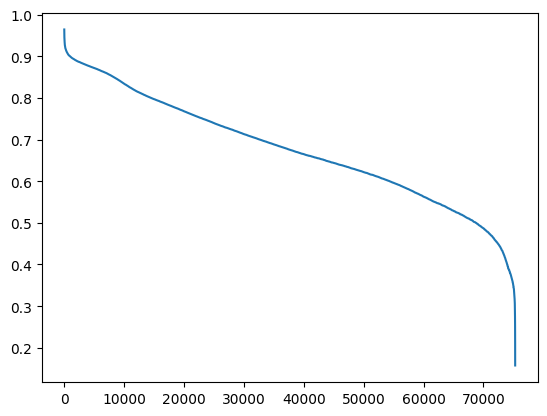

In [53]:
df_similarity['similarity'].plot()